## Direction

## Target=お弁当の売り上げ数を予測(回帰問題)

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic",style="white")

Duplicate key in file PosixPath('/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 250 ('font.family : IPAexGothic')


## 基礎分析

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)
print("Data Shapes")
print("Train:",train.shape, "Test:",test.shape, "Sample:",sample.shape)

Data Shapes
Train: (207, 12) Test: (40, 11) Sample: (40, 2)


In [6]:
train.index = pd.to_datetime(train["datetime"])
train.head()

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,,
2013-11-18,2013-11-18,90,月,0,厚切りイカフライ,NaN,NaN,NaN,NaN,快晴,--,19.8
2013-11-19,2013-11-19,101,火,1,手作りヒレカツ,NaN,NaN,NaN,NaN,快晴,--,17.0
2013-11-20,2013-11-20,118,水,0,白身魚唐揚げ野菜あん,NaN,NaN,NaN,NaN,快晴,--,15.5
2013-11-21,2013-11-21,120,木,1,若鶏ピリ辛焼,NaN,NaN,NaN,NaN,快晴,--,15.2
2013-11-22,2013-11-22,130,金,1,ビッグメンチカツ,NaN,NaN,NaN,NaN,快晴,--,16.1


In [7]:
train.describe()

,y,soldout,kcal,payday,temperature
count,207.000000,207.000000,166.000000,10.0,207.000000
mean,86.623188,0.449275,404.409639,1.0,19.252174
std,32.882448,0.498626,29.884641,0.0,8.611365
min,29.000000,0.000000,315.000000,1.0,1.200000
25%,57.000000,0.000000,386.000000,1.0,11.550000
50%,78.000000,0.000000,408.500000,1.0,19.800000
75%,113.000000,1.000000,426.000000,1.0,26.100000
max,171.000000,1.000000,462.000000,1.0,34.600000


In [8]:
train.describe(include="O")  #include object

,datetime,week,name,remarks,event,weather,precipitation
count,207,207,207,21,14,207,207
unique,207,5,156,6,2,7,8
top,2014-2-17,木,タンドリーチキン,お楽しみメニュー,ママの会,曇,--
freq,1,43,6,12,9,53,169


## 欠損値補間と月情報の特徴量の作成

In [9]:
train["payday"] = train["payday"].fillna(0)
train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x))
train["event"] = train["event"].fillna("なし")
train["remarks"] = train["remarks"].fillna("なし")
train["month"] = train["datetime"].apply(lambda x : int(x.split("-")[1]))

In [10]:
train["precipitation"].value_counts()

-1.0    169
 0.0     23
 0.5      9
 1.5      2
 2.5      1
 1.0      1
 6.5      1
 6.0      1
Name: precipitation, dtype: int64

## お弁当の売り上げ分布の確認

<AxesSubplot:xlabel='datetime'>

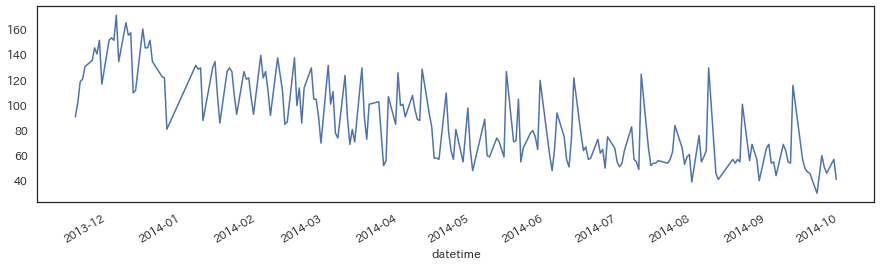

In [11]:
train["y"].plot(figsize=(15,4))

- 経時変化あり
- スパイクあり

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

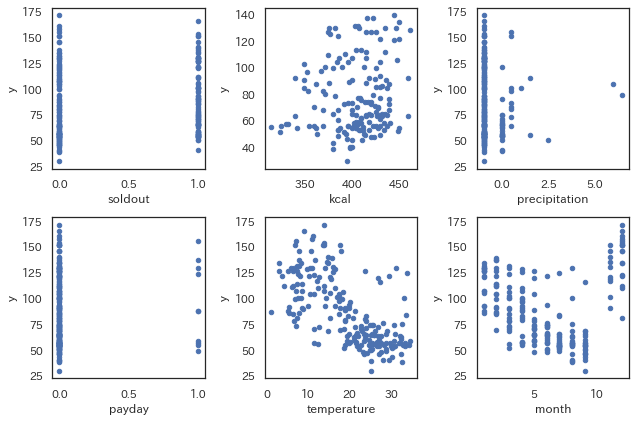

In [12]:
fig, ax = plt.subplots(2,3,figsize=(9,6))                         #2行3列
train.plot.scatter(x="soldout", y="y", ax=ax[0][0])
train.plot.scatter(x="kcal", y="y", ax=ax[0][1])
train.plot.scatter(x="precipitation", y="y", ax=ax[0][2])
train.plot.scatter(x="payday", y="y", ax=ax[1][0])
train.plot.scatter(x="temperature", y="y", ax=ax[1][1])
train.plot.scatter(x="month", y="y", ax=ax[1][2])
plt.tight_layout()

temperatureとmonthが相関ありそう
（ただし時間依存あるので代替変数の可能性高い）

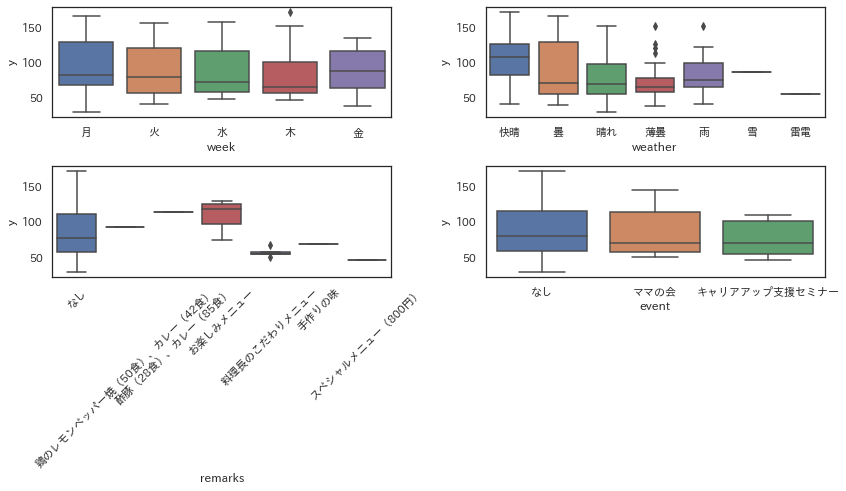

In [13]:
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=45)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

お楽しみメニュー有り無しが影響ありそう

お楽しみメニューあり

<AxesSubplot:xlabel='datetime'>

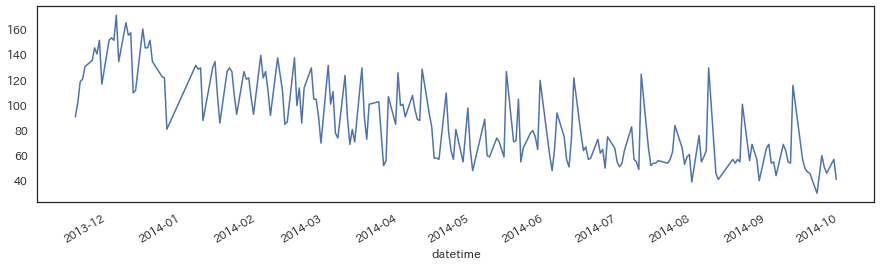

In [14]:
train["y"].plot(figsize=(15,4))

お楽しみメニューなし

<AxesSubplot:xlabel='datetime'>

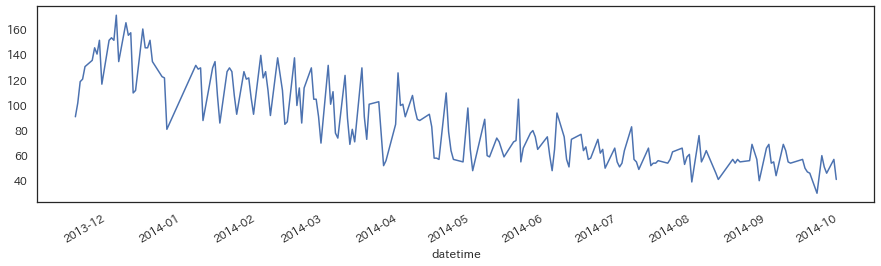

In [15]:
train[train["remarks"]!="お楽しみメニュー"]["y"].plot(figsize=(15,4))

お楽しみメニューを除いても、まだスパイクあり

<AxesSubplot:xlabel='fun', ylabel='y'>

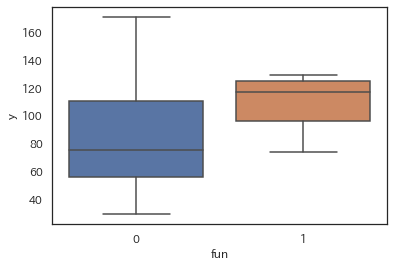

In [16]:
train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
sns.boxplot(x="fun",y="y",data=train)

## 中央値検定(メディアン検定)

2標本それぞれについてmより大きい（もしくはm以上の）データの件数とm以下（もしくはm未満）のデータの件数を求め、2行×2列の分割表を作成する。この分割表に対してカイ二乗検定を行い、2標本の分布が独立かどうかを検定する。

In [17]:
from scipy.stats import median_test
stat,p,med,tbl = median_test(train[train["fun"]==1]["y"],train[train["fun"]==0]["y"])
print("p",p,"stat",stat)

p 0.007057960766247775 stat 7.2581589841730345


p値が0.05以下なので有意差あり

↓お楽しみメニューだけでも差はあり

<AxesSubplot:xlabel='datetime'>

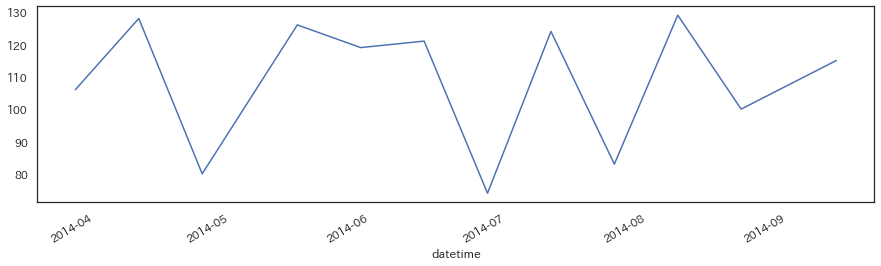

In [18]:
train[train["remarks"]=="お楽しみメニュー"]["y"].plot(figsize=(15,4))

In [19]:
train[train["remarks"]=="お楽しみメニュー"]

,datetime,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature,month,fun
datetime,,,,,,,,,,,,,,
2014-03-28,2014-3-28,106,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,18.5,3,1
2014-04-11,2014-4-11,128,金,1,チキンカレー,NaN,お楽しみメニュー,なし,0.0,快晴,-1.0,16.5,4,1
2014-04-25,2014-4-25,80,金,0,中華丼,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,20.8,4,1
2014-05-16,2014-5-16,126,金,0,ポークカレー,NaN,お楽しみメニュー,ママの会,0.0,快晴,-1.0,23.8,5,1
2014-05-30,2014-5-30,119,金,0,チキンカレー,NaN,お楽しみメニュー,なし,0.0,薄曇,-1.0,26.9,5,1
2014-06-13,2014-6-13,121,金,0,キーマカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,29.5,6,1
2014-06-27,2014-6-27,74,金,0,牛丼,NaN,お楽しみメニュー,なし,0.0,雨,0.0,25.4,6,1
2014-07-11,2014-7-11,124,金,0,ポークカレー,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.9,7,1
2014-07-25,2014-7-25,83,金,0,ひやしたぬきうどん・炊き込みご飯,NaN,お楽しみメニュー,なし,0.0,晴れ,-1.0,33.6,7,1


カレーの時が高そう

<AxesSubplot:xlabel='curry', ylabel='y'>

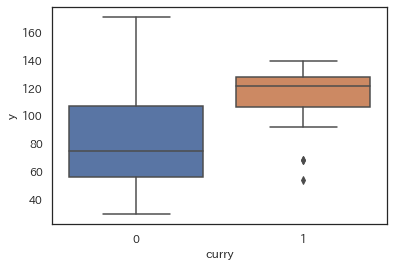

In [20]:
train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
sns.boxplot(x="curry",y="y",data=train)

In [21]:
stat,p,med,tbl = median_test(train[train["curry"]==1]["y"],train[train["curry"]==0]["y"])
print("p:",p,"stat",stat)

p: 0.010699742900892427 stat 6.514516162828877


## Method

In [22]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)

In [23]:
train["t"] = 1
test["t"] = 0
dat = pd.concat([train,test],sort=True).reset_index(drop=True)      #Concatenate 鎖状につなぐ

In [24]:
dat.index = pd.to_datetime(dat["datetime"])
dat = dat["2014-05-01":]
dat = dat.reset_index(drop=True)

dat["days"] = dat.index
dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)
dat["fun"] = dat["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
dat["curry"] = dat["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)

cols = ["precipitation","weather","days","fun","curry","y"]

<ipython-input-24-b1ea195b507c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dat["precipitation"] = dat["precipitation"].apply(lambda x : -1 if x=="--" else x).astype(np.float)


In [25]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF

In [26]:
def learning(trainX,y_train):
    model1 = LR()
    model2 = RF(n_estimators=100,max_depth=4,random_state=None)
    model1.fit(trainX["days"].values.reshape(-1,1),y_train)
    pred = model1.predict(trainX["days"].values.reshape(-1,1))
    
    pred_sub = y_train - pred
    model2.fit(trainX.iloc[:, ~trainX.columns.str.match("y")],pred_sub)
    return model1, model2

## Evaluation

In [27]:
kf = KFold(n_splits=5,random_state=None)
tr = dat[dat["t"]==1][cols]

trains = []
tests = []
for train_index, test_index in kf.split(tr):
    tr.loc[train_index,"tt"] = 1
    tr.loc[test_index,"tt"] = 0
    tr["tt"] = tr["tt"].astype(np.int)
    tmp = pd.get_dummies(tr)
    
    trainX = tmp[tmp["tt"]==1]
    del trainX["tt"]
    testX = tmp[tmp["tt"]==0]
    del testX["tt"]
    y_train = tmp[tmp["tt"]==1]["y"]
    y_test = tmp[tmp["tt"]==0]["y"]
    
    model1, model2 = learning(trainX, y_train)
    
    pred_train = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:, ~trainX.columns.str.match("y")])
    pred_test = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:, ~testX.columns.str.match("y")])
    
    print("TRAIN:",MSE(y_train,pred_train)**0.5, "VARIDATE",MSE(y_test, pred_test)**0.5)
    trains.append(MSE(y_train,pred_train)**0.5)
    tests.append(MSE(y_test, pred_test)**0.5)
print("AVG")
print(np.array(trains).mean(), np.array(tests).mean())

<ipython-input-27-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tr["tt"] = tr["tt"].astype(np.int)
<ipython-input-27-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for m

TRAIN: 7.641954620015155 VARIDATE 11.894311186084026
TRAIN: 7.910262362061451 VARIDATE 10.268497832475537
TRAIN: 8.348733731761453 VARIDATE 8.905185964707654
TRAIN: 7.938099252859778 VARIDATE 19.158093698274875
TRAIN: 7.938038210355463 VARIDATE 9.823546540042114
AVG
7.95541763541066 12.009927044316843


<ipython-input-27-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tr["tt"] = tr["tt"].astype(np.int)
<ipython-input-27-a40c539803fc>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for m

In [28]:
cols = ["precipitation","weather","days","fun","curry","y","t"]
tmp = pd.get_dummies(dat[cols])
trainX = tmp[tmp["t"]==1]
del trainX["t"]
testX = tmp[tmp["t"]==0]
del testX["t"]
y_train = tmp[tmp["t"]==1]["y"]
y_test = tmp[tmp["t"]==0]["y"]

RMSE 8.034245693395157


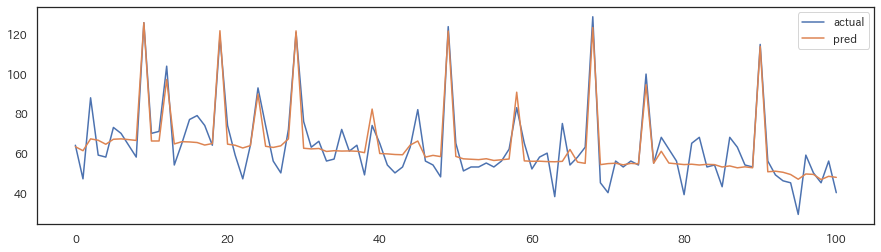

In [29]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(trainX["days"].values.reshape(-1,1)) + model2.predict(trainX.iloc[:,~trainX.columns.str.match("y")])

p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))
print("RMSE",MSE(y_train,pred)**0.5)

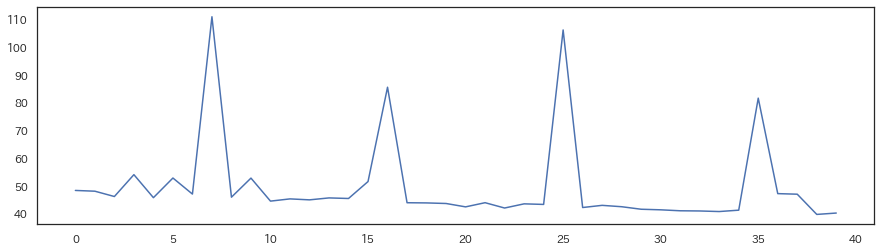

In [30]:
model1, model2 = learning(trainX,y_train)
pred = model1.predict(testX["days"].values.reshape(-1,1)) + model2.predict(testX.iloc[:,~testX.columns.str.match("y")])
plt.figure(figsize=(15,4))
plt.plot(pred)

In [31]:
sample[1] = pred
sample.to_csv("submit9.csv",index=None,header=None)